In [2]:
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
)  
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import (
    preprocess_input,
)  # Preprocessing function specific to EfficientNet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr 
from PIL import Image

In [3]:
testpath = "./EWasteClassificationDataset/modified-dataset/test/"
trainpath = "./EWasteClassificationDataset/modified-dataset/train/"
validpath = "./EWasteClassificationDataset/modified-dataset/val/"

In [5]:
datatrain = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32,
    validation_split=False,
)

Found 2400 files belonging to 10 classes.


In [6]:
datatest = tf.keras.utils.image_dataset_from_directory(
    testpath,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32,
    validation_split=False,
)

Found 300 files belonging to 10 classes.


In [7]:
datavalid = tf.keras.utils.image_dataset_from_directory(
    validpath,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32,
    validation_split=False,
)

Found 300 files belonging to 10 classes.


In [8]:
print(len(datatrain.class_names))
print(datatrain.class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


2025-07-04 07:09:45.344632: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


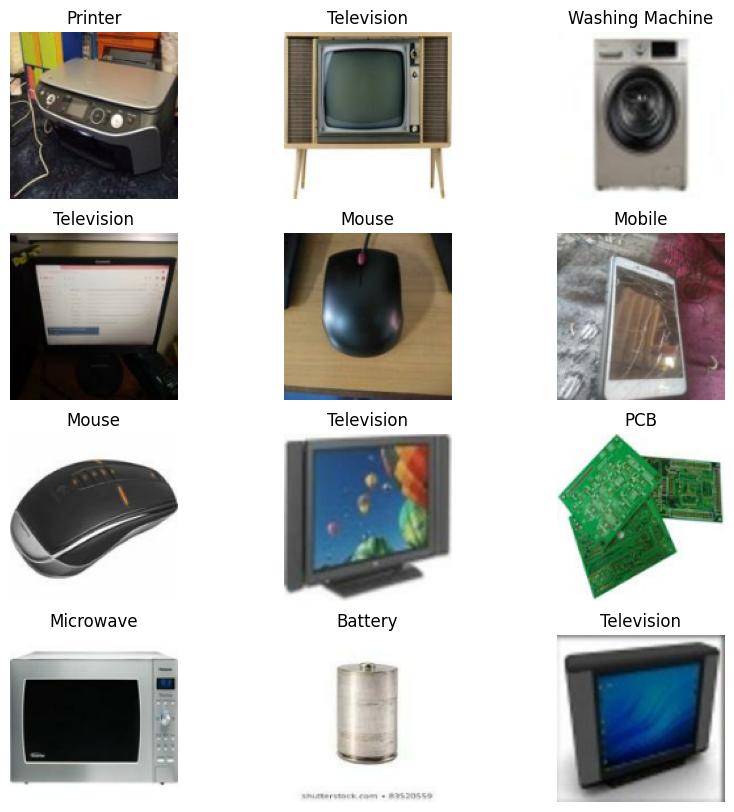

In [10]:
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(datatrain.class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [11]:
def plot_class_distribution(dataset, title="Class Distribution"):

    class_counts = {}

    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
            
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class


    # Create the bar plot
    plt.figure(figsize=(8, 4))  # Set the figure size
    plt.bar(class_names, counts, color='#5865F2')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


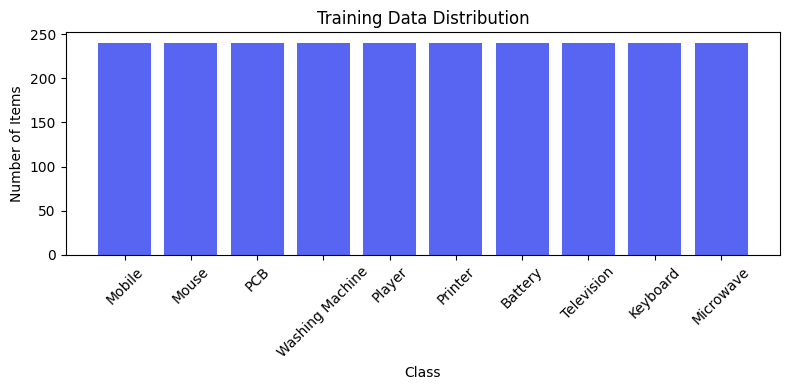

2025-07-04 07:10:15.225330: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


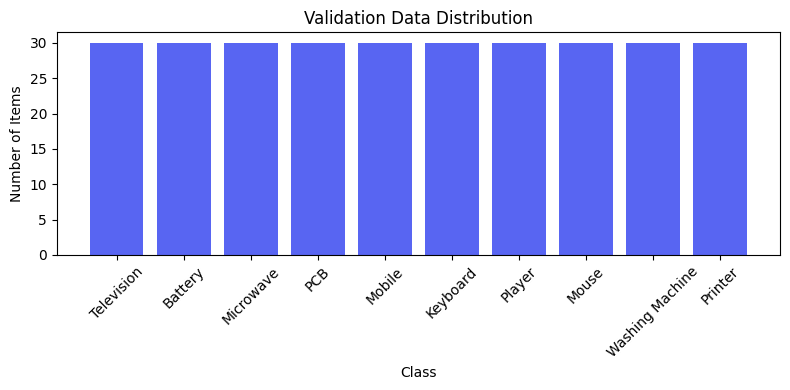

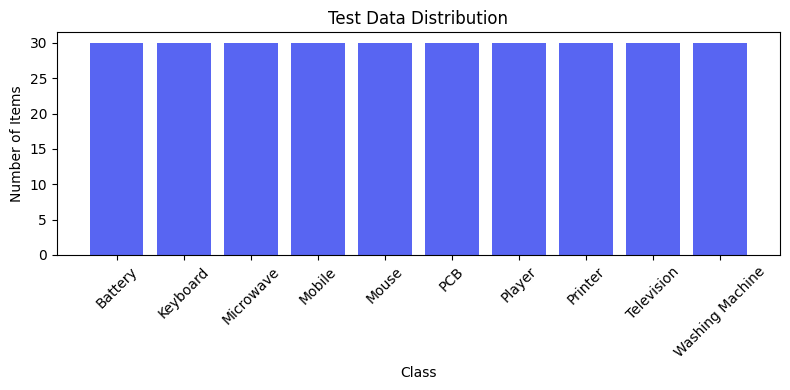

In [12]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

In [13]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [14]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [16]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True   
)


In [17]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 480ms/step - Accuracy: 0.2501 - loss: 2.1391 - val_Accuracy: 0.8067 - val_loss: 1.1715
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 420ms/step - Accuracy: 0.7817 - loss: 1.0084 - val_Accuracy: 0.9133 - val_loss: 0.5112
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - Accuracy: 0.8553 - loss: 0.5515 - val_Accuracy: 0.9433 - val_loss: 0.3014
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - Accuracy: 0.9040 - loss: 0.3505 - val_Accuracy: 0.9467 - val_loss: 0.2252
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 427ms/step - Accuracy: 0.9220 - loss: 0.2771 - val_Accuracy: 0.9567 - val_loss: 0.1832
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 417ms/step - Accuracy: 0.9366 - loss: 0.2153 - val_Accuracy: 0.9633 - val_loss: 0.1710
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 422ms/step - Accuracy: 0.9618 - loss: 0.1616 - val_Accuracy: 0.9667 - val_loss: 0.1633
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 427ms/step - Accuracy: 0.9636 - loss: 0.1317 - val_Accu

In [18]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [20]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

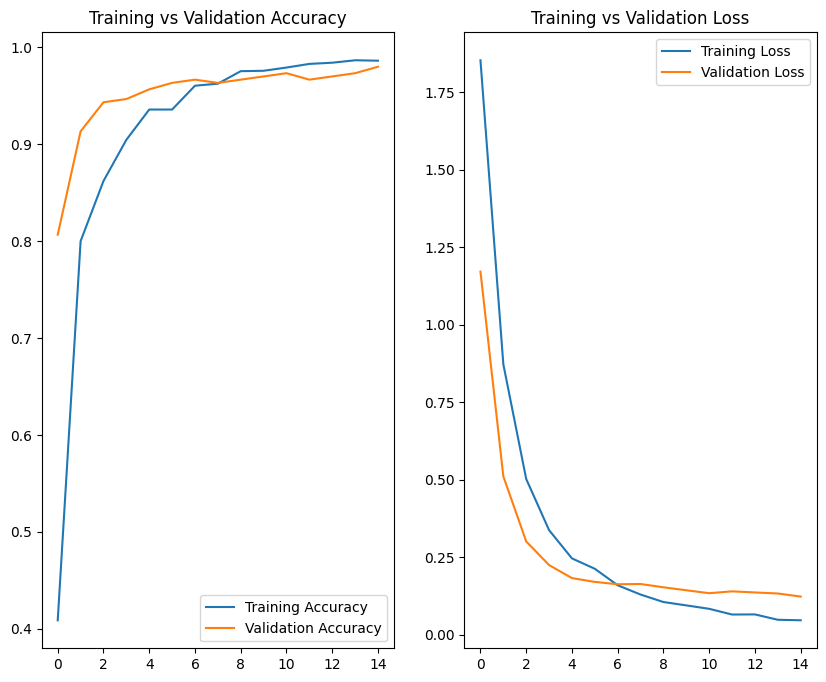

In [21]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [22]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - Accuracy: 0.9587 - loss: 0.1262
Test accuracy is0.9633, Test loss is 0.1108


In [24]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           


print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))                     


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
[[28  0  0  0  0  2  0  0  0  0]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  2  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  2  0  0  0  1  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        30
           1       1.00      0.97      0.98        30
           2       0.88      0.97      0.92        30
           3       1.00      0.97      0.98        30
           4       1.00      0.97      0.98        30
           5       0.91      1.00      0.95        30
           6       0.97      0.93      0.95        30
           7       0.94      1.00      0.97        30
           8       1.00      0.90      0.95        30
           9       1.00      1.00      1.00        30

    accuracy                    

In [25]:
model = tf.keras.models.load_model('Efficient_classify.keras')

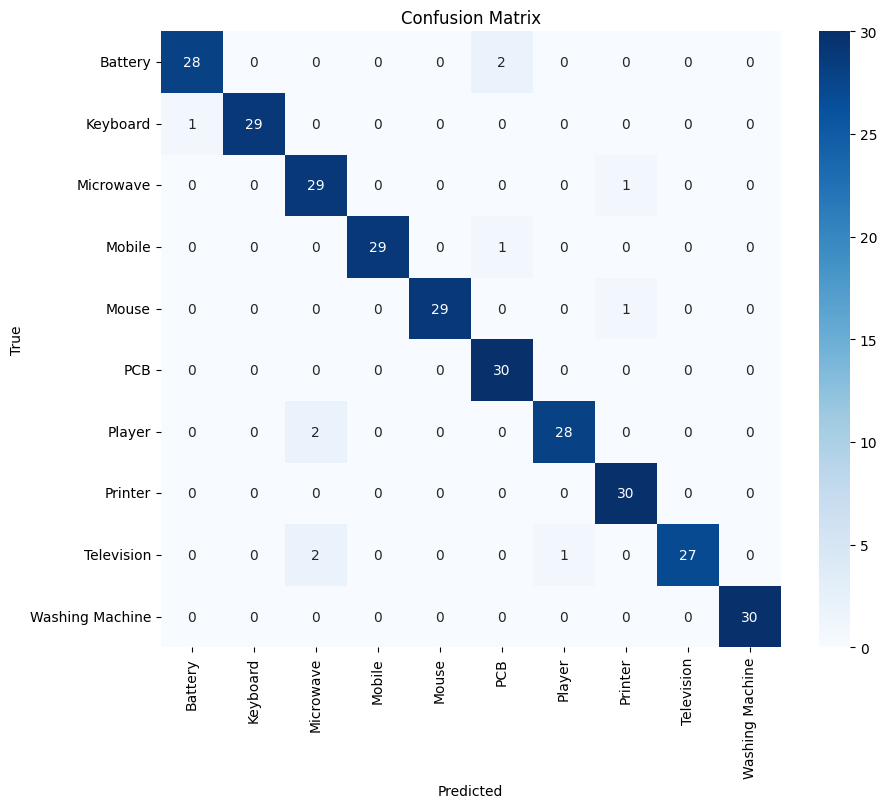

In [26]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=datatest.class_names, 
            yticklabels=datatest.class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025-07-04 07:27:05.692792: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


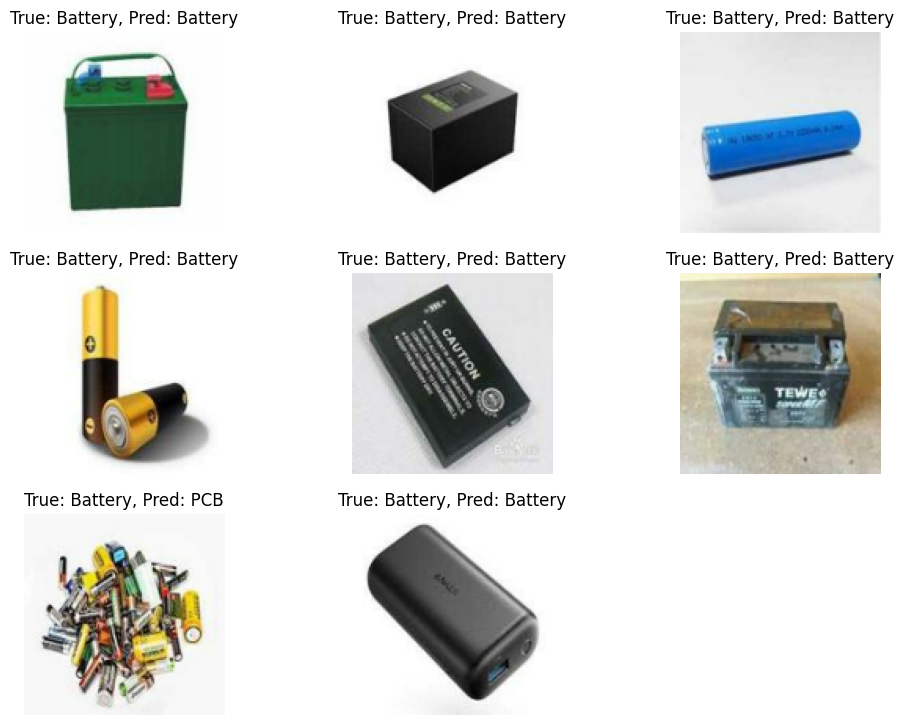

In [27]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset
plt.figure(figsize=(12, 12))

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):
        ax = plt.subplot(4, 3, i + 1)                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes

plt.show()                                                          # Show image
                                                   # Show image


In [ ]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [28]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [ ]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://dcd5b1f59078308eab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
